In [1]:
from plot_disk import grcor
import matplotlib.pyplot as plt
import astropy.constants as c
import astropy.units as u
import numpy as np

def r_grav(m):
    grav_radius = ((c.G * m) / (c.c**2))
    return grav_radius.to(u.cm)

def f_function(a, r, M):
    qcor, tcor = grcor(a, r/r_grav(M))
    return tcor**4

def F_gr(a, r, r_in, M, Mdot):
    flux = 3. * c.G * M * Mdot / (8. * np.pi * r**3) * f_function(a, r, M)    # Calculate the flux
    flux[flux<0.] = 0.
    return flux.to(u.Unit("erg/(cm2 s)"))


Here are the functions we know and love! The last one gives us the flux as a function of radius using the GR function you wrote in the last tutorial. In this bit of code, we want to make a plot of the radiative efficiency as a function of black hole spin. This is a bit more complicated than it sounds for the GR case, but the Newtonian gravity case is fairly easy since there's just an equation for it:

In [2]:
def rad_efficiency_newtonian(M, r_in):
    return (c.G * M / (2. * c.c.cgs**2. * r_in)).decompose()


M = 6.62*u.solMass
rad_efficiency_newtonian(M,  6*r_grav(M))

<Quantity 0.08333333>

Excellent! This is the exact result we expect analytically: 1/12. This tells us that the radiative efficiency of a black hole with interior radius set to 6 gravitational radii is always 1/12 --- that is, 1/12 of the energy produced by the infalling material is expelled as light.

**But how do we add GR?**
This is where things get tricky. Not only does the radiative efficiency now depend on the black hole spin, but *so does the interior radius*, `r_in`. We need a new function that tells us what interior radius to use if we have a certain value set for `a`, the black hole spin parameter. Here's the code for that:

In [3]:
def get_r_isco(a, M):
    z1 = 1 + np.cbrt(1 - a**2) * (np.cbrt(1 + a) + np.cbrt(1 - a))
    z2 = np.sqrt(3*a**2 + z1**2)
    r_isco = (c.G * M / c.c.cgs**2 * (3 + z2 - np.sqrt((3-z1) * (3 + z1 + 2*z2)))).to(u.cm)
    return r_isco

This radius, called the "ISCO" for Innermost Stable Circular Orbit, is a value that should be equal to 6 gravitational radii for a non-spinning black hole and 1 gravitational radius for a maximally spinning black hole. Remember that non-spinning means `a=0`, and maximally-spinning is `a=1`. We also need to be able to calculate all values in between. Let's test it out.

In [4]:
# NON-spinning case
a = 0
M = 6.62*u.solMass

print(get_r_isco(a, M))
print(get_r_isco(a, M)/r_grav(M))

5865154.651135095 cm
6.000000000000001


In [5]:
# Maximally-spinning case
a = 0.9999999999
M = 6.62*u.solMass

print(get_r_isco(a, M))
print(get_r_isco(a, M)/r_grav(M))

978246.4867973599 cm
1.00073728143694


Excellent! This ISCO function gives us the correct number of gravitational radii to use for `r_in`, depending on what value of `a` we want to plug in. Now, we need to use this to calculate the radiative efficiency using a numerical integral. Here's how that works:

In [6]:
import scipy.integrate
def get_efficiency(r_in, r_out, a, M, Mdot):
    # Create an array of radii to integrate over
    r_array = np.linspace(r_in, r_out, 1000)
    integrand = 4*np.pi*r_array*F_gr(a, r_array, r_in, M, Mdot)
    #luminosity = np.trapz(integrand, r_array)
    luminosity = scipy.integrate.simps(integrand, r_array) * u.erg / u.s
    return (luminosity / (Mdot * c.c.cgs**2)).decompose()

So, now we can call the two functions together after setting our parameters to get the radiative efficiency in the GR case.

In [7]:
a = 0.999999999
M = 6.62 * u.solMass
Mdot = 0.000025 * u.solMass / u.yr
r_in = get_r_isco(a, M)
r_out = 500 * r_grav(M) # Set this waaay far out for the integration to be accurate

In [8]:
get_efficiency(r_in, r_out, a, M, Mdot)

<Quantity 0.44693458>

This is very close to the expected theoretical GR result! Now let's write some code to get and store this efficiency for a set of values for `a`. We'll also recalculate the Newtonian efficiency using the values for r_isco that we generate along the way, because this also has an effect on the efficiency.

In [9]:
M = 6.62 * u.solMass
Mdot = 0.000025 * u.solMass / u.yr
r_out = 500 * r_grav(M)
a_vals = [1e-8, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999999999]
gr_efficiency_vals = []
newt_efficiency_vals = []
for a in a_vals:
    r_in = get_r_isco(a, M)
    efficiency = get_efficiency(r_in, r_out, a, M, Mdot)
    gr_efficiency_vals.append(efficiency)
    newt_efficiency_vals.append(rad_efficiency_newtonian(M, r_in))

/home/connor/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


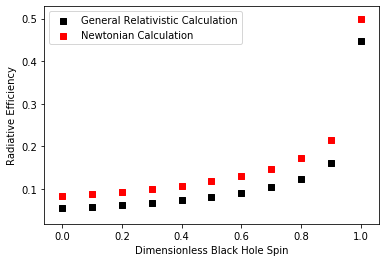

In [10]:
plt.scatter(a_vals, gr_efficiency_vals, marker='s', c='k', label='General Relativistic Calculation')
plt.scatter(a_vals, newt_efficiency_vals, marker='s', c='r', label='Newtonian Calculation')
#plt.axhline(rad_efficiency_newtonian(M, 6*r_grav(M)), c='r', label="Newtonian Gravity Calculation")
plt.ylabel("Radiative Efficiency")
plt.xlabel("Dimensionless Black Hole Spin")
plt.legend()
plt.show()

Here we have shown that more rapidly spinning black holes will radiate more energy per unit mass, which means their radiative efficiencies are higher. However, you can see that a Newtonian gravity model will slightly overestimate the radiative efficiency. The effects of General Relativity seem to slighly reduce the ability of black holes to produce radiation.